# Customer Segmentation
Following Steps:
1. Basic Data Exploration and analysis 
2. Data Cleaning
3. Feature Engineering
4. Scaling
5. Clustering
6. Visualization

Objective: Segment customers into distinct groups based on purchasing behaviour.

In [40]:
# Import necessary packages and load data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
import warnings


In [41]:
# load data
data = pd.read_csv("online_retail.csv")
df = data.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Basic Data Exporation and Analysis

In [42]:
# basic details about dataset
def basic_details(df):
    """This function gives basic details about dataset"""
    print("\n Shape of dataframe: ", df.shape)
    print("\n Columns of dataframe: ", df.columns)
    print("\n DataTypes: \n", df.info())
    print("\n Null Values Present in each column: ", df.isna().sum())
    print("\n Duplicate records in dataset: ", df.duplicated().sum())
    print("\n Basic Statistical Summary of numerical columns: ", df.describe())


basic_details(df)



 Shape of dataframe:  (541909, 8)

 Columns of dataframe:  Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

 DataTypes: 
 None

 Null Values Present in each column:  InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
Cus

# Data Cleaning

In [43]:
# dealing duplicate records
df.drop_duplicates(inplace=True)
print("Duplicate records in dataset: ", df.duplicated().sum())


Duplicate records in dataset:  0


In [44]:
# dealing with missing values
"""we got 135088 missing values in customer id which is around 25% and since it'scustomer
   identifier, it's important and we cannot impute. We cannot relate any customer to that
   particular transaction so it's better to drop them. And if anyway we keep them, it might 
   lead to wrong clustering. And regarding description this column is not needed so we can drop"""
df.dropna(subset=['CustomerID'], inplace=True)
print("Missing value in customer id: ",df.isna().sum())

Missing value in customer id:  InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


# Feature Selection
Invoice no: just a transaction id - no direct value for customer segmentation. So dropping it.
StockCode: product id, useful for product clustering, not here, so dropping this too.
Description: Texual product info - not useful for behaviour based clustering.
We are gonna keep all other features.

In [45]:
# dropping above features
df.drop(columns=['InvoiceNo','StockCode','Description'], inplace = True)
df.columns

Index(['Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'], dtype='object')

In [46]:
# crosscheck
# i run above cell twice so got it
df.columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Quantity     401604 non-null  int64  
 1   InvoiceDate  401604 non-null  object 
 2   UnitPrice    401604 non-null  float64
 3   CustomerID   401604 non-null  float64
 4   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 18.4+ MB
None


In [47]:
# we will convert invoice date to date time and customer id to string.
df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Quantity     401604 non-null  int64         
 1   InvoiceDate  401604 non-null  datetime64[ns]
 2   UnitPrice    401604 non-null  float64       
 3   CustomerID   401604 non-null  object        
 4   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 18.4+ MB
None


In [48]:
# Now we will generate RFM features.
"""Recency, Frequency and Monetary Value per customer id
   RFM Analysis: How recently a customer made a purchase (R),
                 How often they purchase in a given time frame (F),
                 How much money a customer spends (M).
    It helps us understand customer behaviour based on three key aspect RFM"""

# creating a snapshot date - reference date to compare all purchases against to calculate receny
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create a new 'TotalPrice' column first
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Then calculate RFM
rfm = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    Frequency=('InvoiceDate', 'count'),
    Monetary=('TotalPrice', 'sum')
).reset_index()

rfm

#Here we used tuple () style with .agg() function.
#  .agg(NewCol=('col','func')) is the syntax


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40
...,...,...,...,...
4367,18280.0,278,10,180.60
4368,18281.0,181,7,80.82
4369,18282.0,8,13,176.60
4370,18283.0,4,721,2045.53


In [49]:
# R score: recent purchase means high score (recent purchase)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)

# F & M scores: higher is better (more purchases/money spent)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Optional: Combine them to a single RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [50]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,2,0.00,1,1,1,111
1,12347.0,2,182,4310.00,5,5,5,555
2,12348.0,75,31,1797.24,2,3,4,234
3,12349.0,19,73,1757.55,4,4,4,444
4,12350.0,310,17,334.40,1,2,2,122


In [51]:
# Segment Customers on Individual score we can later add complexity
def segment_customer(rfm):
    if rfm['R_Score'] >= 4 and rfm['F_Score'] >= 4:
        return 'Loyal'
    elif rfm['R_Score'] >= 4:
        return 'Recent'
    elif rfm['F_Score'] >= 4:
        return 'Frequent'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,326,2,0.00,1,1,1,111,Others
1,12347.0,2,182,4310.00,5,5,5,555,Loyal
2,12348.0,75,31,1797.24,2,3,4,234,Others
3,12349.0,19,73,1757.55,4,4,4,444,Loyal
4,12350.0,310,17,334.40,1,2,2,122,Others


# Scaling

In [52]:
# Scaling - Recency, Frequency and Monetary to get standard scale
# R,F,M Score are already on standard scale of 1 to 5
# Here we are not using RFM Score, we may use it later
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])
rfm_scaled

array([[ 2.32202285, -0.39205597, -0.23041952],
       [-0.89373323,  0.39329343,  0.29405454],
       [-0.1691956 , -0.26552745, -0.01171748],
       ...,
       [-0.83418219, -0.34406239, -0.20892947],
       [-0.87388289,  2.74497857,  0.01849636],
       [-0.48680114, -0.09536842, -0.00684511]])

# Clustering

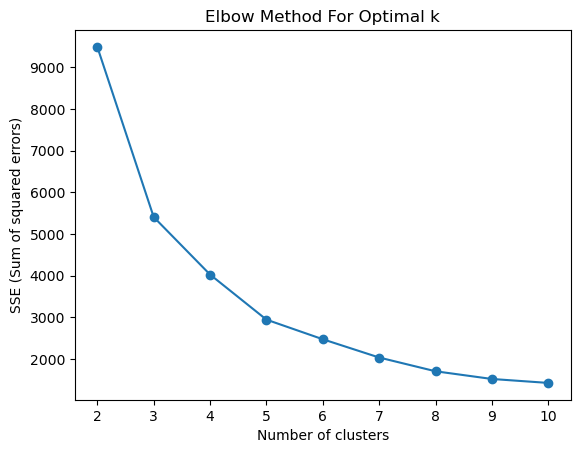

In [53]:
# Let's use KMeans Clustering
# to find the optimal number of cluster we will use elbow method i.e k = ?
from sklearn.cluster import KMeans

sse = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Sum of squared errors)')
plt.title('Elbow Method For Optimal k')
plt.show()


In [54]:
# Creating KMeans Clustering object
k = 5  # from above observations
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [55]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster
0,12346.0,326,2,0.00,1,1,1,111,Others,1
1,12347.0,2,182,4310.00,5,5,5,555,Loyal,0
2,12348.0,75,31,1797.24,2,3,4,234,Others,0
3,12349.0,19,73,1757.55,4,4,4,444,Loyal,0
4,12350.0,310,17,334.40,1,2,2,122,Others,1


In [56]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_summary)

# Here we used dict {} style in .agg() with .agg({'col':'funct'})


        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0          43.4      73.1    1282.1  3045
1         249.8      27.3     465.2  1070
2           2.0    5824.2   64463.6     4
3           9.0    1012.2  192037.9     5
4          12.3     489.3   10720.4   248


# Visualization

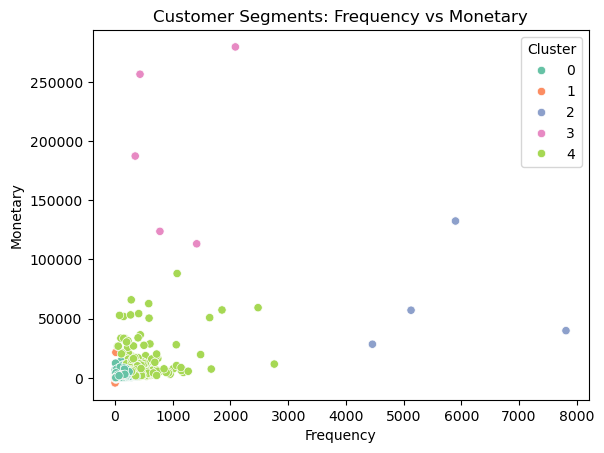

In [57]:
# Frequency vs Monetary

sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments: Frequency vs Monetary')
plt.show()


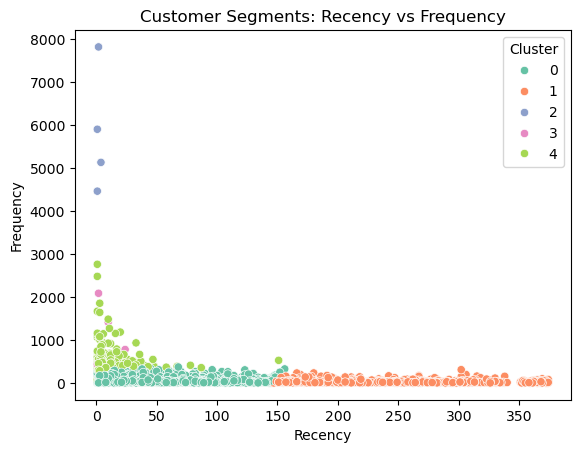

In [58]:
# Recency vs Frequency
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set2')
plt.title('Customer Segments: Recency vs Frequency')
plt.show()


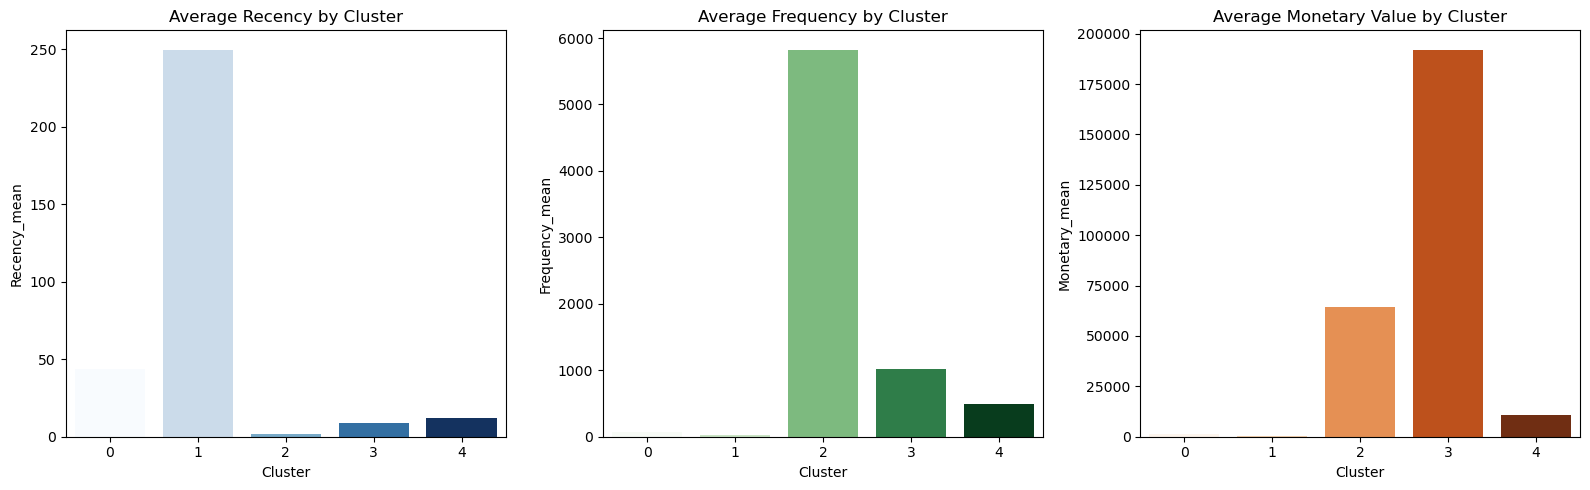

In [59]:
# Bar plot for cluster summary


cluster_summary.columns = ['Recency_mean', 'Frequency_mean', 'Monetary_mean', 'Count']

# Reset index to turn Cluster into a column
cluster_summary = cluster_summary.reset_index()

# Plotting
plt.figure(figsize=(16, 5))

# Recency
plt.subplot(1, 3, 1)
sns.barplot(x='Cluster', y='Recency_mean', hue= 'Cluster', data=cluster_summary, palette='Blues', legend=False)
plt.title('Average Recency by Cluster')

# Frequency
plt.subplot(1, 3, 2)
sns.barplot(x='Cluster', y='Frequency_mean', hue='Cluster', data=cluster_summary, palette='Greens', legend=False)
plt.title('Average Frequency by Cluster')

# Monetary
plt.subplot(1, 3, 3)
sns.barplot(x='Cluster', y='Monetary_mean', hue = 'Cluster', data=cluster_summary, palette='Oranges', legend=False)
plt.title('Average Monetary Value by Cluster')

plt.tight_layout()
plt.show()


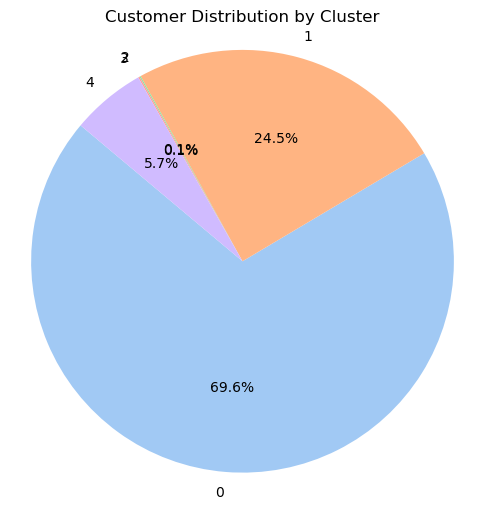

In [60]:
# Clsuter Size Visualization
# Pie chart of customer count per cluster
plt.figure(figsize=(6, 6))
plt.pie(cluster_summary['Count'], labels=cluster_summary['Cluster'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Customer Distribution by Cluster')
plt.axis('equal')
plt.show()
